HW3

1. Attain optimal portfolio weights
2. Attain maximum sharpe ratio portfolio weights consisting of following assets (AAPL, IBM, MSFT)
3. Attain minimum variance portfolio weightsconsisting of the same assets

You should include weights of each asset
- e.g. AAPL: 27.63%, IBM: 58.81%, MSFT: 13.56% for max sharpe weights
- RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
- START_DATE = '2018-01-01'
- END_DATE = '2018-12-31'


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
warnings.simplefilter(action='ignore', category=FutureWarning)

Finding efficient frontier using Monte carlo simulations

In [3]:
#import libraries
!pip install yfinance
import yfinance as yf
!pip install numpy
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 397 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#set up parameters
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [5]:
#download from yfinance
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


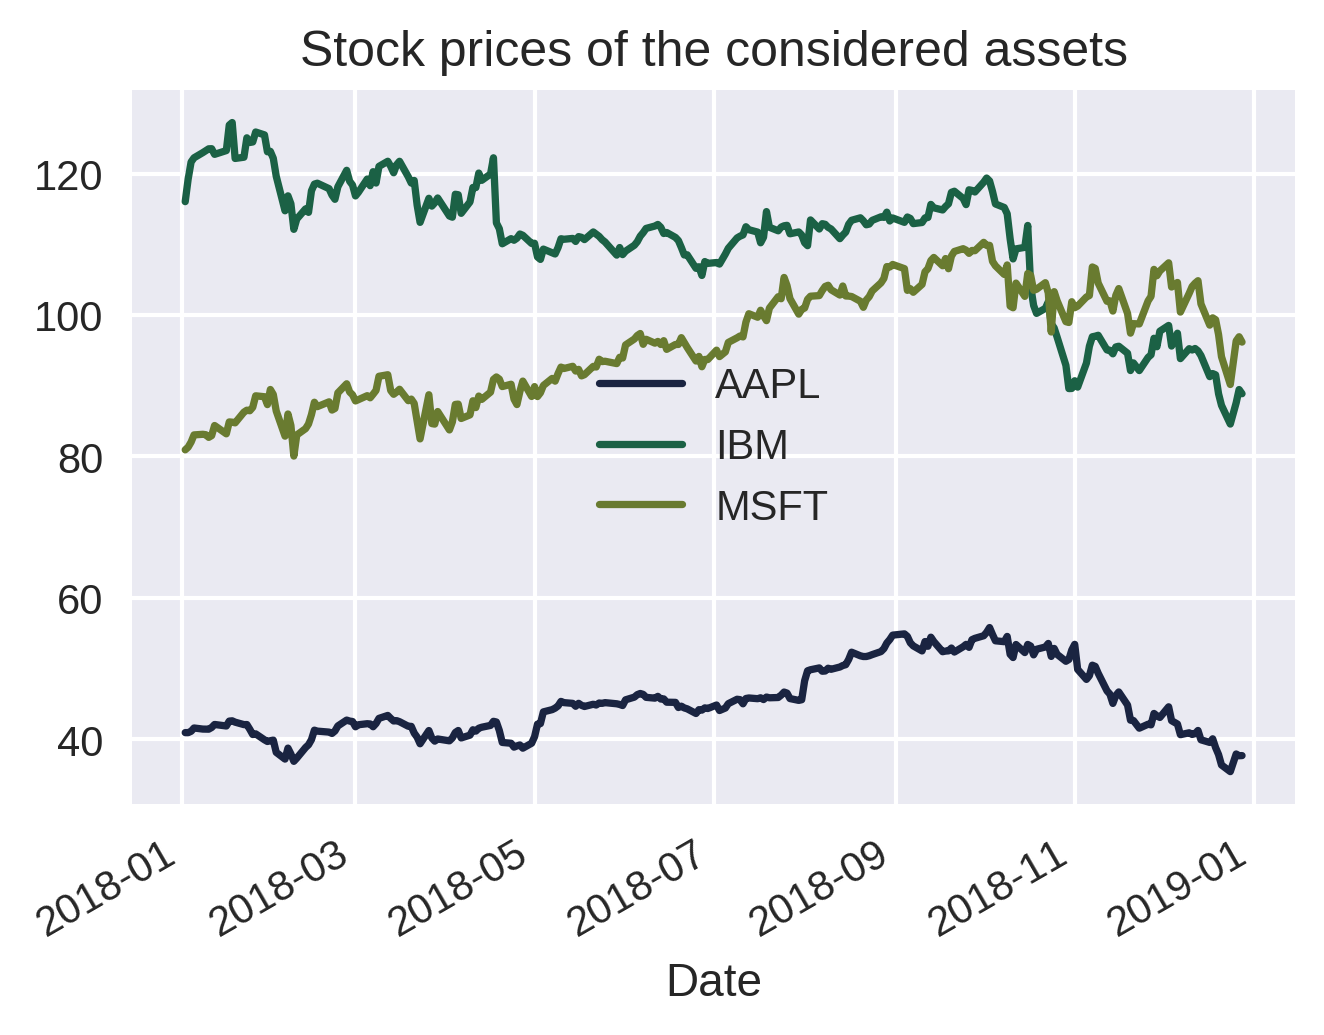

In [6]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

In [7]:
#calculate annualized average returns and the corresponding standard deviation
returns_df = prices_df["Adj Close"].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
sd_mat = cov_mat ** 0.5

In [8]:
#simulate random portfolio weights
weights = np.random.random(size = (N_PORTFOLIOS, n_assets)) #simulates random weights but they don't add up to 100% yet
one_row = tuple(weights.sum(axis=1)) #calculates the sum of each row so we can divide each element later by that sum
sum = np.column_stack((one_row, one_row, one_row))
weights = weights / sum #by dividing by the sum we get weights that add up to 100% in each row
weights[18238]


array([0.43825665, 0.22448824, 0.33725511])

In [9]:
#calculate protfolio metrics: portfolio returns, portfolio_volatility, portfolio_sharpe_ratio
portf_returns = np.dot(weights, avg_returns)
portf_returns

portf_vol = []
for i in range(0, len(weights)):
  portf_vol.append(np.sqrt(np.dot(weights[i].T,np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)

portf_sharpe = portf_returns / portf_vol

In [10]:
#create a joint dataframe with all results
portf_results_df = pd.DataFrame({"returns": portf_returns, "volatility": portf_vol, "sharpe_ratio": portf_sharpe})
portf_results_df

,returns,volatility,sharpe_ratio
0,0.113521,0.256955,0.441793
1,-0.072948,0.229816,-0.317419
2,0.059468,0.255171,0.233051
3,0.048157,0.243381,0.197868
4,-0.058501,0.231880,-0.252288
...,...,...,...
99995,0.064679,0.257170,0.251502
99996,0.025135,0.240765,0.104395
99997,0.037612,0.240483,0.156403
99998,0.042586,0.241404,0.176411


In [11]:
#Locate points creating efficient frontier
N_POINTS = 100 
portf_vol_ef = []
indices_to_skip = []

portf_returns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_returns_ef = np.round(portf_returns_ef, 2)
portf_returns = np.round(portf_returns, 2)

for point_index in range(N_POINTS): 
    if portf_returns_ef[point_index] not in portf_returns: 
         indices_to_skip.append(point_index) 
         continue 
    matched_ind = np.where(portf_returns == portf_returns_ef[point_index]) 
    # return elements chosen from x or y depending on condition
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_returns_ef = np.delete(portf_returns_ef, indices_to_skip)

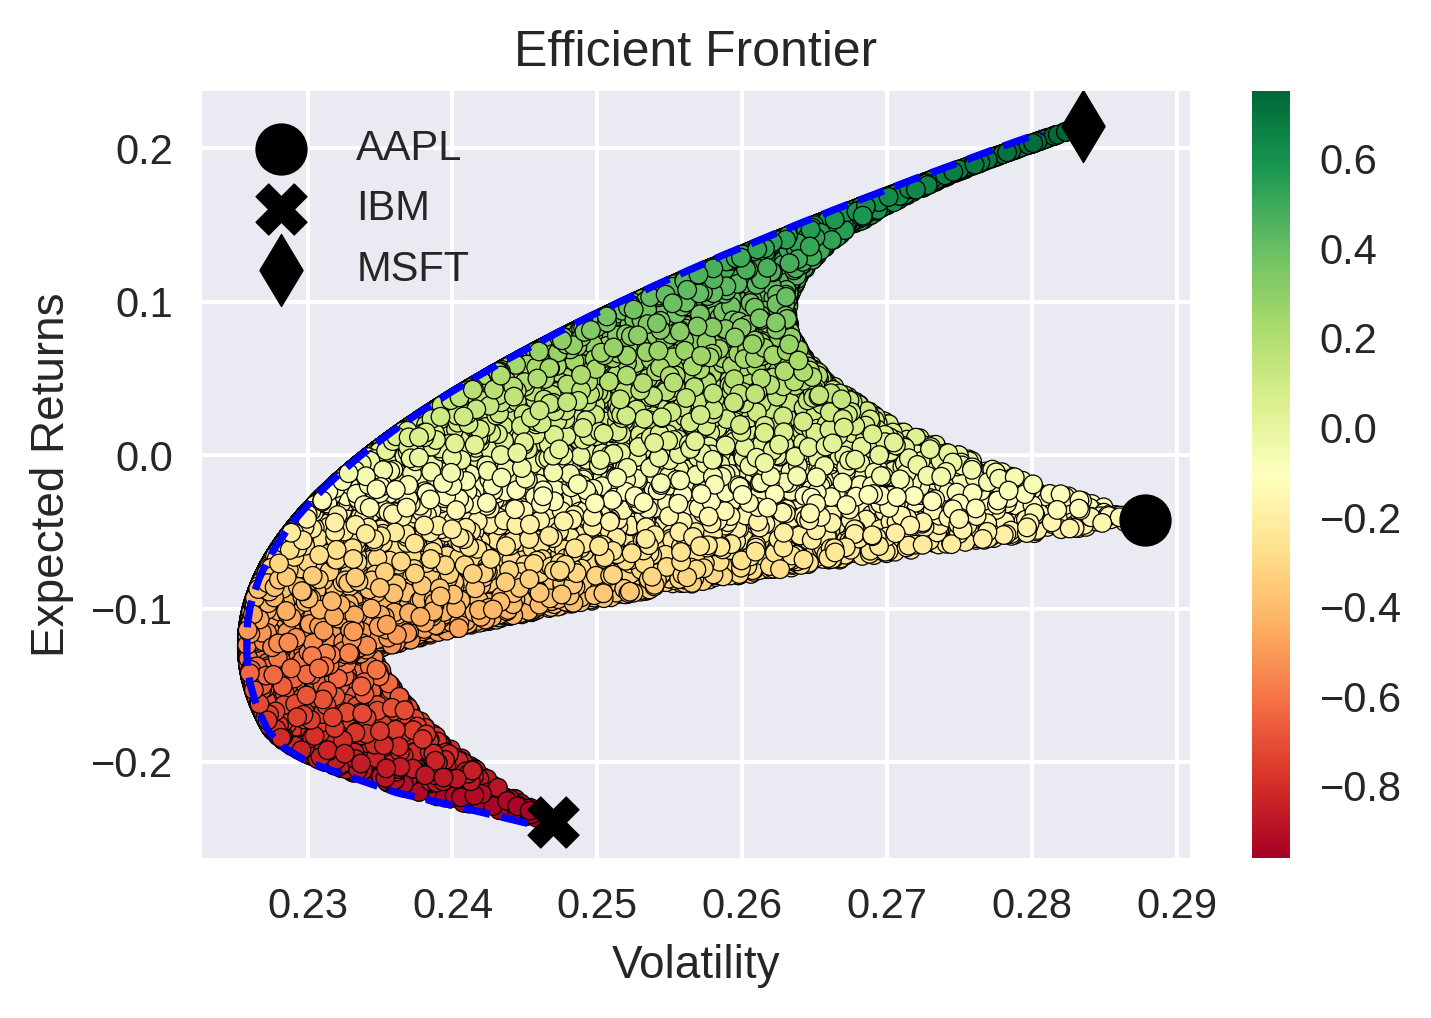

In [12]:
#plot efficient frontier
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c=portf_sharpe,
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_returns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

1. Attain optimal portfolio weights
2. Attain maximum sharpe ratio portfolio weights consisting of following assets (AAPL, IBM, MSFT)
3. Attain minimum variance portfolio weights consisting of the above assets

In [13]:
#attain maximum sharpe ratio portfolio weights
max_sharpe = portf_results_df["sharpe_ratio"].max()
max_sharpe_index = list(portf_results_df["sharpe_ratio"]).index(max_sharpe)
weights_max_sharpe = weights[max_sharpe_index]
weights_max_sharpe

array([4.90807712e-04, 3.93966177e-03, 9.95569531e-01])

In [14]:
#attain minimum variance portfolio weights
min_vol = portf_results_df["volatility"].min()
min_vol_index = list(portf_results_df["volatility"]).index(min_vol)
weights_min_vol = weights[min_vol_index]
weights_min_vol

array([0.27777474, 0.58822521, 0.13400005])

HW 4
- for the 2 portfolio weights gained in HW3, use numerical simulations
- make a monte carlo simulation for the two portfolios

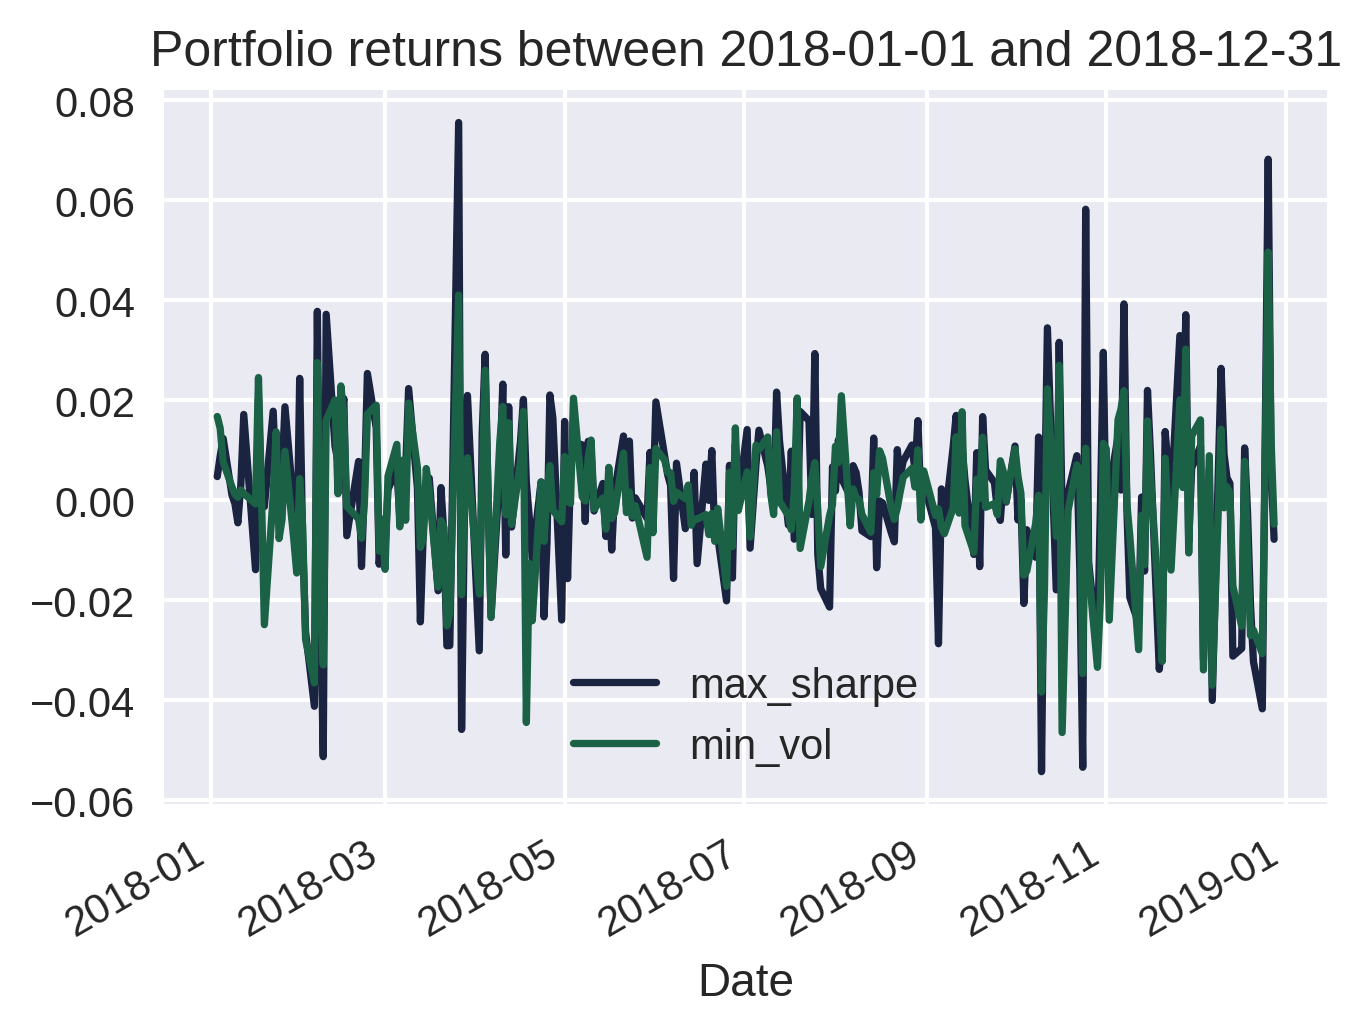

In [15]:
max_sharpe_portf_rtn = (returns_df * weights_max_sharpe).sum(axis = 1) #gives a time series of portfolio returns of maximum sharpe ratio portfolio
min_vol_portf_rtn = (returns_df * weights_min_vol).sum(axis = 1) #gives a time series of portfolio returns of minimum volatility portfolio
max_sharpe_portf_value = (prices_df["Adj Close"] * weights_max_sharpe).sum(axis = 1)
min_vol_portf_value = (prices_df["Adj Close"] * weights_min_vol).sum(axis = 1)

#plot the two portfolios
max_sharpe_portf_rtn.plot(label = "max_sharpe")
min_vol_portf_rtn.plot(label = "min_vol")
plt.legend()
plt.title(f"Portfolio returns between {START_DATE} and {END_DATE}")
plt.show()

In [16]:
#split data into training and test set
#max stands for max_sharpe portfolio and min stands for min_vol portfolio
train_max = max_sharpe_portf_rtn["2018-01-01":"2018-11-30"]
test_max = max_sharpe_portf_rtn["2018-12-01":"2018-12-31"]
train_min = min_vol_portf_rtn["2018-01-01":"2018-11-30"]
test_min = min_vol_portf_rtn["2018-12-01":"2018-12-31"]

In [18]:
#specify parameters of the simulation
T = len(test_max)
N = len(test_max) 
s_0_max = max_sharpe_portf_value[train_max.index[-1]] #starting price in the monte carlo simulation for max sharpe portf
s_0_min = min_vol_portf_value[train_min.index[-1]] #starting price in the monte carlo simulation for min vol portf
N_SIM = 1000 
mu_max = train_max.mean()
sigma_max = train_max.std()
mu_min = train_min.mean()
sigma_min = train_min.std()

In [19]:
#random walk model
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    #the ''' are used to make multi-line comments
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [20]:
#run the simulation
sim_max_sharpe = simulate_gbm(s_0_max, mu_max, sigma_max, N_SIM, T, N)
sim_min_vol = simulate_gbm(s_0_min, mu_min, sigma_min, N_SIM, T, N)

In [ ]:
#plot max sharpe
# prepare objects for plotting 
last_train_date = train_max.index[-1].date()
first_test_date = test_max.index[0].date()
last_test_date = test_max.index[-1].date()
plot_title = (f'Simulation of max sharpe portfolio')

selected_indices = max_sharpe_portf_value[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(sim_max_sharpe), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, max_sharpe_portf_value[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()

In [ ]:
#plot min vol
# prepare objects for plotting 
last_train_date = train_min.index[-1].date()
first_test_date = test_min.index[0].date()
last_test_date = test_min.index[-1].date()
plot_title = (f'Simulation of min vol portfolio')

selected_indices = min_vol_portf_value[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(sim_min_vol), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, min_vol_portf_value[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()